In [347]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_curve,f1_score
import seaborn as sns
from tqdm import tqdm


def load_file(name):
    file = pd.read_csv(name)
    file.set_index("PassengerId",inplace = True)
    file = file.to_numpy().astype(float)
    return file

X_test = load_file("Preprocessed_Data/X_test.csv")
X_train = load_file("Preprocessed_Data/X_train.csv")
y_test = load_file("Preprocessed_Data/y_test.csv").ravel()
y_train = load_file("Preprocessed_Data/y_train.csv").ravel()
target = load_file("Preprocessed_Data/target.csv")

target_index = pd.read_csv("Preprocessed_Data/target.csv")
target_index = target_index["PassengerId"]

In [348]:
def stack(stacking_models):
    estimators = list(stacking_models.items())    
    clf = ensemble.StackingClassifier(estimators = estimators[0:len(estimators)-1], final_estimator=estimators[-1][1])
    return clf

In [349]:
from xgboost import XGBClassifier
from sklearn import svm, neighbors, ensemble
stacking_models = {
    "svc": svm.SVC(kernel = "linear", C = 0.025),
    "rfc": ensemble.RandomForestClassifier(n_estimators = 500, warm_start = True, n_jobs = -1, max_depth = 8),
    "ada": ensemble.AdaBoostClassifier(n_estimators = 500, learning_rate = 0.75),
    "gb": ensemble.GradientBoostingClassifier(n_estimators = 500, max_depth = 6, verbose = False),
    "ext": ensemble.ExtraTreesClassifier(n_estimators = 500, n_jobs = -1, max_depth = 6),
    "xgb": XGBClassifier(n_estimators = 2000, objective = "binary:logistic", )
} 

clf = stack(stacking_models)

models = stacking_models.copy()
models["clf"] = clf

In [350]:
output = {}
for i in tqdm(models):
    model = models[i]
    model.fit(X_train,y_train,)
    output[i] = np.round(model.score(X_test,y_test),2)
output = {k: v for k, v in sorted(output.items(), key=lambda item: item[1])}

100%|██████████| 7/7 [00:31<00:00,  4.55s/it]


In [351]:
output

{'ada': 0.82,
 'svc': 0.84,
 'gb': 0.84,
 'rfc': 0.85,
 'xgb': 0.85,
 'clf': 0.85,
 'ext': 0.86}

In [352]:
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

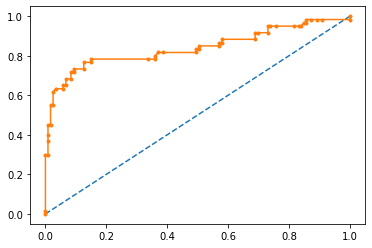

0.448


In [357]:
predictions = models["clf"].predict_proba(X_test)
yhat = predictions[:, 1]
fpr, tpr, thresholds = roc_curve(y_test.reshape(-1, 1), yhat)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='clf')
plt.show()

thresholds = np.arange(0, 1, 0.001)
scores = [f1_score(y_test, to_labels(yhat, t)) for t in thresholds]
ix = thresholds[np.argmax(scores)]
print(ix)

In [354]:
from datetime import datetime
predictions = models["clf"].predict_proba(target)
predictions = [1 if x >= 0.4 else 0 for x in predictions[:,1]]
df = pd.DataFrame(predictions,columns=["Survived"])
df.index = target_index
df.index.name = 'PassengerId'
now = datetime.now()
now = now.strftime("%Y.%m.%d.%H.%M")
df.to_csv("Predictions/{}.csv".format(now))